# Analyse mutations of created sequences

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import random
import os
sys.path.append("..")
from global_variables import *
from escape_map import EscapeMap, load_escape_map_from_csv,gen_artif_data, score_seq_batch
from utils import get_Kd

In [28]:
exp_df=pd.read_csv('df_exp_complete.csv')
exp_df['mutation_list'].iloc[1]
exp_df = exp_df[~exp_df['condition'].str.contains('_', na=False)]


In [29]:
all_mut_df=pd.read_csv('../seq_data/all_mutation_summary.csv')
all_mut_df.rename(columns={'count_100': 'count'}, inplace=True)
all_mut_df

,mutation,count,first_seen_100
0,M1I,4,NaN
1,M1L,6,NaN
2,M1V,1,NaN
3,F2C,10,NaN
4,F2H,1,NaN
...,...,...,...
9860,T1273K,8,NaN
9861,T1273P,4,NaN
9862,T1273R,2,NaN
9863,T1273S,43,NaN


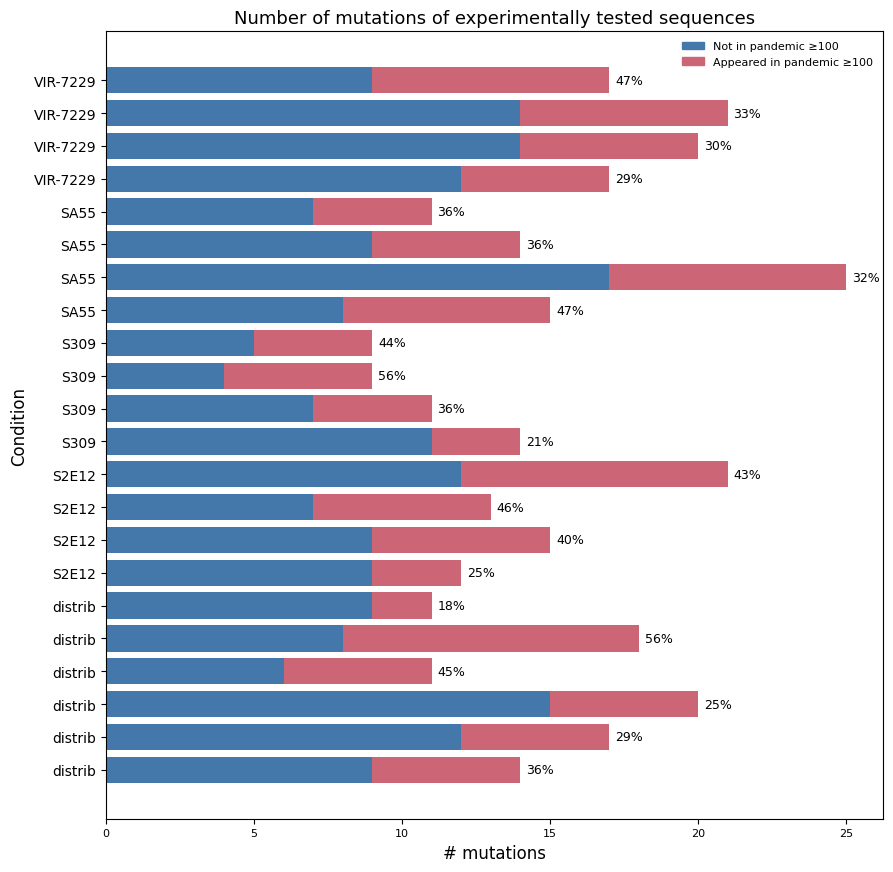

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# --- 0) Baseline from all_mut_df ---
all_mut_df["mutation"] = all_mut_df["mutation"].astype(str).str.strip()
possible_mutations = set(all_mut_df["mutation"])
pandemic_muts = set(all_mut_df.loc[all_mut_df["count"] >= 100, "mutation"])
baseline = (len(pandemic_muts) / max(1, len(possible_mutations)))  # avoid div/0

# --- 1) Choose an ID column for sequences ---
id_col='condition'

# --- 2) Filter out 'wt' and 'ba1' (case-insensitive, exact match) ---
_mask = ~exp_df[id_col].astype(str).str.lower().isin({"wt", "ba1"})
exp_df_plot = exp_df.loc[_mask].copy()

# --- 3) Parse mutation lists ---
def _parse_mut_list(s):
    if pd.isna(s) or not str(s).strip():
        return []
    return [t.strip() for t in str(s).split(",") if t.strip()]

mut_lists = exp_df_plot["mutation_list"].apply(_parse_mut_list)

# counts: total, pandemic≥100, non-pandemic
n_total = mut_lists.apply(len)
n_pandemic = mut_lists.apply(lambda L: sum(m in pandemic_muts for m in L))
n_nonpandemic = n_total - n_pandemic

# percentage of existing mutations (present anywhere in all_mut_df, any count)
n_exist_any = mut_lists.apply(lambda L: sum(m in possible_mutations for m in L))
pct_existing = np.where(n_total.values > 0, n_exist_any.values / n_total.values, 0.0)

summary = pd.DataFrame({
    id_col: exp_df_plot[id_col].astype(str),
    "n_mut_total": n_total.values,
    "n_mut_pandemic": n_pandemic.values,
    "n_mut_nonpandemic": n_nonpandemic.values,
    "pct_existing": pct_existing
})

# --- 4) Order by sequence id (ascending, natural order if there are numbers) ---
def _nat_key(s):
    s = str(s)
    parts = re.split(r'(\d+)', s)
    return tuple(int(p) if p.isdigit() else p.lower() for p in parts)

summary = summary.sort_values(by=id_col, key=lambda col: col.map(_nat_key)).reset_index(drop=True)

# --- 5) Plot: stacked horizontal bars ---
plt.figure(figsize=(9, max(3, 0.4 * len(summary))))
ypos = np.arange(len(summary))
col_nonpand = "#4477AA"
col_pand = "#CC6677"
# blue = not-pandemic, red = pandemic
bars_nonpand = plt.barh(ypos, summary["n_mut_nonpandemic"], color=col_nonpand, label="Not in pandemic ≥100")
bars_pand = plt.barh(ypos, summary["n_mut_pandemic"],
                     left=summary["n_mut_nonpandemic"], color=col_pand, label="Appeared in pandemic ≥100")

plt.yticks(ypos, summary[id_col], fontsize=10)
plt.xlabel("# mutations", fontsize=12)
plt.ylabel("Condition", fontsize=12)

plt.title("Number of mutations of experimentally tested sequences", fontsize=13)
# Replace 'pct_existing' with percentage of mutations seen ≥100 times
summary["pct_ge100"] = np.where(
    summary["n_mut_total"] > 0,
    summary["n_mut_pandemic"] / summary["n_mut_total"],
    0.0
)

# --- 6) Annotate percentage of existing mutations just to the right of each bar ---
x_totals = summary["n_mut_total"].values
for y, x, p in zip(ypos, x_totals, summary["pct_ge100"].values):
    plt.text(x + 0.2, y, f"{p:.0%}", va="center", ha="left", fontsize=9)


# --- 7) Legend including baseline ---
# Add a dummy (invisible) patch that carries the baseline text
# baseline_label = f"Baseline: {baseline:.1%} appeared ≥100 times in pandemic"
legend_handles = [
    plt.Rectangle((0,0), 1, 1, color=col_nonpand, label="Not in pandemic ≥100"),
    plt.Rectangle((0,0), 1, 1, color=col_pand, label="Appeared in pandemic ≥100"),
    # plt.Rectangle((0,0), 0, 0, alpha=0.0, label=baseline_label)  # invisible, for text only
]
plt.legend(handles=legend_handles, loc="best", frameon=False)

plt.tight_layout()
plt.show()

# Keep the dataset if needed later
seq_mut_counts = summary.copy()


In [44]:
summary["pct_ge100"].mean()

0.3689407621493182